In [4]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from scipy import sparse 

In [32]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [5]:
class CF(object):
    """docstring for CF"""
    def __init__(self, Y_data, k, dist_func = cosine_similarity, uuCF = 1):
        self.uuCF = uuCF # user-user (1) or item-item (0) CF
        self.Y_data = Y_data if uuCF else Y_data[:, [1, 0, 2]]
        self.k = k
        self.dist_func = dist_func
        self.Ybar_data = None
        # number of users and items. Remember to add 1 since id starts from 0
        self.n_users = int(np.max(self.Y_data[:, 0])) + 1 
        self.n_items = int(np.max(self.Y_data[:, 1])) + 1
    
    def add(self, new_data):
        """
        Update Y_data matrix when new ratings come.
        For simplicity, suppose that there is no new user or item.
        """
        self.Y_data = np.concatenate((self.Y_data, new_data), axis = 0)
    
    def normalize_Y(self):
        users = self.Y_data[:, 0] # all users - first col of the Y_data
        self.Ybar_data = self.Y_data.copy()
        self.mu = np.zeros((self.n_users,))
        for n in range(self.n_users):
            # row indices of rating done by user n
            # since indices need to be integers, we need to convert
            ids = np.where(users == n)[0].astype(np.int32)
            # indices of all ratings associated with user n
            item_ids = self.Y_data[ids, 1] 
            # and the corresponding ratings 
            ratings = self.Y_data[ids, 2]
            # take mean
            m = np.mean(ratings) 
            if np.isnan(m):
                m = 0 # to avoid empty array and nan value
            self.mu[n] = m
            # normalize
            self.Ybar_data[ids, 2] = ratings - self.mu[n]

        ################################################
        # form the rating matrix as a sparse matrix. Sparsity is important 
        # for both memory and computing efficiency. For example, if #user = 1M, 
        # #item = 100k, then shape of the rating matrix would be (100k, 1M), 
        # you may not have enough memory to store this. Then, instead, we store 
        # nonzeros only, and, of course, their locations.
        self.Ybar = sparse.coo_matrix((self.Ybar_data[:, 2],
            (self.Ybar_data[:, 1], self.Ybar_data[:, 0])), (self.n_items, self.n_users))
        self.Ybar = self.Ybar.tocsr()

    def similarity(self):
        eps = 1e-6
        self.S = self.dist_func(self.Ybar.T, self.Ybar.T)
    
        
    def refresh(self):
        """
        Normalize data and calculate similarity matrix again (after
        some few ratings added)
        """
        self.normalize_Y()
        self.similarity() 
        
    def fit(self):
        self.refresh()
        
    
    def __pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        # Step 1: find all users who rated i
        ids = np.where(self.Y_data[:, 1] == i)[0].astype(np.int32)
        # Step 2: 
        users_rated_i = (self.Y_data[ids, 0]).astype(np.int32)
        # Step 3: find similarity btw the current user and others 
        # who already rated i
        sim = self.S[u, users_rated_i]
        # Step 4: find the k most similarity users
        a = np.argsort(sim)[-self.k:] 
        # and the corresponding similarity levels
        nearest_s = sim[a]
        # How did each of 'near' users rated item i
        r = self.Ybar[i, users_rated_i[a]]
        if normalized:
            # add a small number, for instance, 1e-8, to avoid dividing by 0
            return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8)

        return (r*nearest_s)[0]/(np.abs(nearest_s).sum() + 1e-8) + self.mu[u]
    
    def pred(self, u, i, normalized = 1):
        """ 
        predict the rating of user u for item i (normalized)
        if you need the un
        """
        if self.uuCF: return self.__pred(u, i, normalized)
        return self.__pred(i, u, normalized)
            
    
    def recommend(self, u, num=None):
        """
        Determine all items should be recommended for user u.
        The decision is made based on all i such that:
        self.pred(u, i) > 0. Suppose we are considering items which 
        have not been rated by u yet. 
        """
        ids = np.where(self.Y_data[:, 0] == u)[0]
        items_rated_by_u = self.Y_data[ids, 1].tolist()              
        recommended_items = []
        [recommended_items.append((i, self.__pred(u,i))) for i in range(self.n_items) if i not in items_rated_by_u and self.__pred(u,i) > 0]
        # for i in range(self.n_items):
        #     if i not in items_rated_by_u:
        #         rating = self.__pred(u, i)
        #         if rating > 0: 
        #             recommended_items.append(i)
        recommended_items.sort(key=lambda tup: tup[1], reverse=True)
        
        # return recommended_items 
        return [item[0] for item in recommended_items][:num]

    def print_recommendation(self, num):
        """
        print all items which should be recommended for each user 
        """
        print('Recommendation: ')
        for u in range(self.n_users):
            recommended_items = self.recommend(u, num)
            if self.uuCF:
                print('    Recommend item(s):', recommended_items, 'for user', u)
            else: 
                print('    Recommend item', u, 'for user(s) : ', recommended_items)

In [6]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']

ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols, encoding='latin-1')

# indices start from 0
# rate_train[:, :2] -= 1
# rate_test[:, :2] -= 1

/tmp/ipykernel_13222/3914173650.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('data/ml-1m/ratings.dat', sep='::', names=r_cols, encoding='latin-1')


In [7]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
ratings.dtypes

user_id           int64
movie_id          int64
rating            int64
unix_timestamp    int64
dtype: object

In [9]:
len(ratings)

1000209

In [10]:
ratings.drop(['unix_timestamp'], axis=1, inplace=True)

In [11]:
ratings.head()

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [12]:
ratings['user_id'] -= 1
ratings['movie_id'] -= 1

In [13]:
ratings_base, ratings_test = train_test_split(ratings, test_size=0.25, random_state=42, shuffle=True, stratify=ratings['user_id'])

In [14]:
ratings_base.head()

,user_id,movie_id,rating
83194,548,2169,1
321574,1906,1091,2
295514,1754,2247,4
620593,3759,2286,3
880884,5320,1951,5


In [15]:
ratings_base = ratings_base.values
ratings_test = ratings_test.values

In [16]:
ratings_base

array([[ 548, 2169,    1],
       [1906, 1091,    2],
       [1754, 2247,    4],
       ...,
       [4259, 2388,    3],
       [4479,  427,    3],
       [1646, 1199,    5]])

In [17]:
rs_uu = CF(ratings_base, k = 30, dist_func=cosine_similarity, uuCF = 1)
rs_uu.fit()

n_tests = ratings_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs_uu.pred(ratings_test[n, 0], ratings_test[n, 1], normalized = 0)
    SE += (pred - ratings_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('User-user CF, RMSE =', RMSE)

User-user CF, RMSE = 0.9225545275974292


In [18]:
pred = []
for n in range(n_tests):
    _pred = rs_uu.pred(ratings_test[n, 0], ratings_test[n, 1], normalized = 0)
    # print("User {:^4} rated {:^4}: truth = {:.3f}, prediction = {:.3f}".format(ratings_test[n, 0],ratings_test[n,1],ratings_test[n,2],pred))
    pred.append(_pred)

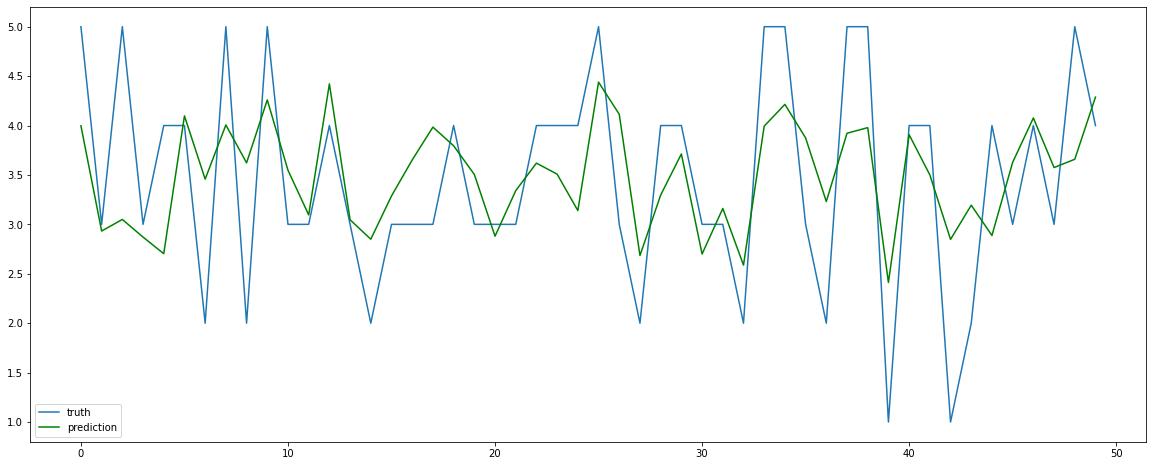

In [36]:
import matplotlib.pyplot as plt
num = 50
plt.figure(figsize=(20,8))
x = range(len(pred))
plt.plot(x[:num],ratings_test[:num, 2], label = "truth")
plt.plot(x[:num], pred[:num], label = "prediction", color="g")
plt.legend()
plt.show()

In [32]:
rs_ii = CF(ratings_base, k = 30, dist_func=cosine_similarity, uuCF = 0)
rs_ii.fit()

n_tests = ratings_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs_ii.pred(ratings_test[n, 0], ratings_test[n, 1], normalized = 0)
    SE += (pred - ratings_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('Item-item CF, RMSE =', RMSE)

/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/dh2409/miniconda3/envs/pDL/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Item-item CF, RMSE = 0.9021015133025637


In [56]:
def similarity(X,Y):
    #X = (n_samples, n_features)
    #Y = (n_samples, n_features)
    X = X.toarray()
    mean_X = np.mean(X,axis=-1)
    mean_X_2 = np.mean(X*X, axis=-1)
    Z = np.zeros((X.shape[0],X.shape[0]))
    for i in range(X.shape[0]):
        for j in range(i,X.shape[0]):
            XY = X[i] * X[j]
            E_XY = np.mean(XY,axis=-1)
            up = E_XY - mean_X[i] * mean_X[j]
            down = np.sqrt(mean_X_2[i] - mean_X[i]*mean_X[i]) * np.sqrt(mean_X_2[j] - mean_X[j]*mean_X[j]) + 1e-3
            Z[i,j] = up / down
    return Z + np.transpose(Z) - np.diag(np.diag(Z))

In [ ]:
rs_uu_v2 = CF(ratings_base, k = 30, dist_func=similarity, uuCF = 1)
rs_uu_v2.fit()

n_tests = ratings_test.shape[0]
SE = 0 # squared error
for n in range(n_tests):
    pred = rs_uu_v2.pred(ratings_test[n, 0], ratings_test[n, 1], normalized = 0)
    SE += (pred - ratings_test[n, 2])**2 

RMSE = np.sqrt(SE/n_tests)
print('User-user CF, RMSE =', RMSE)